# 1. 합성곱 신경망(CNN)

## 1) 합성곱 신경망 기본

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
train_dataset  = torchvision.datasets.FashionMNIST("FashionMNIST/", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_dataset  = torchvision.datasets.FashionMNIST("FashionMNIST/", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))

100%|██████████| 26421880/26421880 [00:01<00:00, 20965211.84it/s]


Extracting FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to FashionMNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 344172.96it/s]


Extracting FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to FashionMNIST/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6332675.44it/s]


Extracting FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to FashionMNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4155557.54it/s]

Extracting FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to FashionMNIST/FashionMNIST/raw



In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=64)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=64)

In [ ]:
next(iter(train_loader))[0][0].shape, next(iter(train_loader))[0][1].shape

(torch.Size([1, 28, 28]), torch.Size([1, 28, 28]))

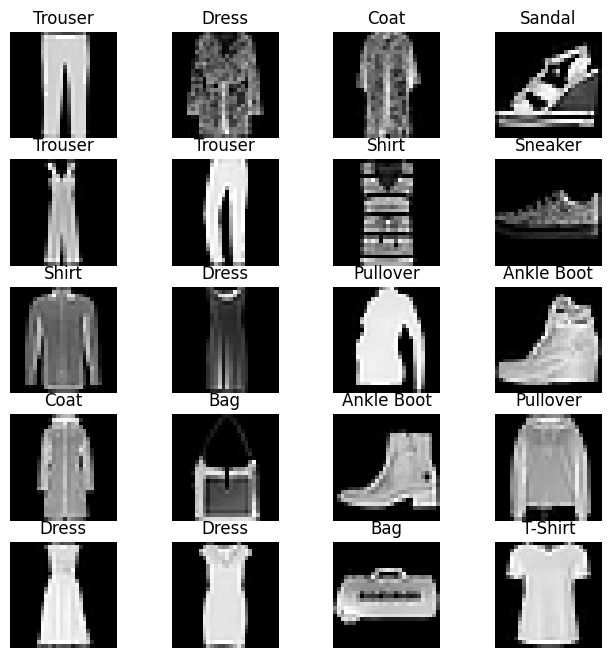

In [ ]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'}

fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_dataset));
    img = train_dataset[img_xy][0][0]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

In [ ]:
class FashionDNN(nn.Module):
    def __init__(self):
        super(FashionDNN,self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=784,out_features=256)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=256,out_features=128)
        self.fc3 = nn.Linear(in_features=128,out_features=10)

    def forward(self,input_data):
        x = self.flatten(input_data)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
learning_rate = 0.01;
model = FashionDNN();
model.to(device)

criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)

FashionDNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
num_epochs = 10

# 학습 및 검증 루프
for epoch in range(num_epochs):
    model.train()  # 학습 모드
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # 에폭이 끝날 때마다 검증
    model.eval()  # 평가 모드
    total = 0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == labels).sum().item()

    val_accuracy = correct * 100 / len(test_dataset)
    print("Epoch: {}, Loss: {}, Accuracy: {}%".format(epoch+1, loss.item(), val_accuracy))

# 최종 결과 출력
print("Training Complete")

Epoch: 1, Loss: 0.5047115683555603, Accuracy: 82.23%
Epoch: 2, Loss: 0.6933919787406921, Accuracy: 82.82%
Epoch: 3, Loss: 0.5721361637115479, Accuracy: 83.86%
Epoch: 4, Loss: 0.41106417775154114, Accuracy: 84.16%
Epoch: 5, Loss: 0.6970487833023071, Accuracy: 84.35%
Epoch: 6, Loss: 0.4574356973171234, Accuracy: 85.02%
Epoch: 7, Loss: 0.5258114337921143, Accuracy: 84.67%
Epoch: 8, Loss: 0.3679131865501404, Accuracy: 85.25%
Epoch: 9, Loss: 0.49503451585769653, Accuracy: 84.82%
Epoch: 10, Loss: 0.6735985279083252, Accuracy: 85.09%
Training Complete


본격적으로 CNN 모델을 구축해보겠습니다.


```nn.Conv2d(in_channels, out_channels, kernel_size, padding)```
- in_channels : 입력 이미지의 채널 수를 의미합니다.
- out_channels : 이 레이어가 출력하는 특징 맵의 채널 수입니다.
- kernel_size=3 : 합성곱 필터의 크기를 정의합니다.
- padding : 합성곱 연산 전에 입력 이미지 주변에 추가되는 픽셀 수를 의미합니다.

<br>

```nn.BatchNorm2d(입력채널 수)```

배치 정규화는 학습 과정에서 각 배치에 대해 평균과 분산을 사용하여 데이터를 정규화합니다. 이는 학습 속도를 높이고, 과적합을 줄이며, 더 안정적인 학습을 도와줍니다.

<br>

```nn.MaxPool2d(kernel_size, stride)```
- kernel_size : 풀링 필터의 크기입니다.
- stride : 풀링 필터가 이동하는 간격입니다.



In [ ]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        # # 첫 번째 합성곱 레이어
        self.layer1 = nn.Sequential(
            # 32개의 필터와 3x3 커널, 패딩 1을 갖는 합성곱 레이어
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # 완전 연결 계층 정의
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [ ]:
learning_rate = 0.01;
model = FashionCNN();
model.to(device)

criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [ ]:
num_epochs = 10

# 학습 및 검증 루프
for epoch in range(num_epochs):
    model.train()  # 학습 모드
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # 에폭이 끝날 때마다 검증
    model.eval()  # 평가 모드
    total = 0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == labels).sum().item()

    val_accuracy = correct * 100 / len(test_dataset)
    print("Epoch: {}, Loss: {}, Accuracy: {}%".format(epoch+1, loss.item(), val_accuracy))

# 최종 결과 출력
print("Training Complete")

이제 문제에 맞게 CNN 모델을 직접 구축해보세요.

문제1. 아래의 조건 순서에 맞는 CNN 모델을 구축하시오.

(활성화 함수는 렐루를 사용하시오.)

- 입력 데이터: (28, 28, 1)
- Conv 레이어 1: 필터 크기 3, 필터 개수 32개, 스트라이드 1, 패딩 'same'
- MaxPooling 레이어 1: 풀링 크기 (2, 2)
- Conv 레이어 2: 필터 크기 3, 필터 개수 64개, 스트라이드 1, 패딩 'same'
- MaxPooling 레이어 2: 풀링 크기 (2, 2)
- Flatten 레이어
- Fully Connected 레이어 1: 유닛 수 128개
- Fully Connected 레이어 2: 유닛 수 10개

In [ ]:
# Sequential을 사용하지 않고


class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()

        # 첫 번째 합성곱 레이어
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 두 번째 합성곱 레이어
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Flatten 레이어
        self.flatten = nn.Flatten()

        # Fully Connected Layers
        self.fc1 = nn.Linear(in_features=64*7*7, out_features=128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        # Conv 레이어 1 + 풀링
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        # Conv 레이어 2 + 풀링
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        # Flatten 레이어
        x = self.flatten(x)

        # Fully Connected Layers
        x = self.fc1(x)
        x = self.relu3(x)  # 첫 번째 Fully Connected Layer
        x = self.fc2(x)  # 출력층
        return x

# 모델 인스턴스 생성 및 출력 크기 확인
model = FashionCNN()
print(model)

FashionCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
sample_image =  next(iter(train_loader))[0]
# 순전파
model(sample_image).shape

torch.Size([64, 10])

In [ ]:
# Sequential 사용

class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()

        # Sequential을 사용하여 레이어 정의
        self.layers1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )


        self.layers2 = nn.Sequential(
            # Flatten 레이어
            nn.Flatten(),
            # Fully Connected Layers
            nn.Linear(in_features=48, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=10),
        )

    def forward(self, x):
        x = self.layers1(x)
        x = self.layers2(x)

        return x

# 모델 인스턴스 생성 및 출력 크기 확인
model = FashionCNN()
print(model)

FashionCNN(
  (layers1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layers2): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [ ]:
sample_image =  next(iter(train_loader))[0]
# 순전파
model(sample_image).shape

torch.Size([64, 10])

문제 1-2. 각 층의 출력값 크기와 파라미터 수를 계산하시오.
- 입력 데이터: (28, 28, 1)
- Conv 레이어 1: 필터 크기 3, 필터 개수 32개, 스트라이드 1, 패딩 'same'
    - 출력 크기 : (28, 28, 32)
    - 파라미터 수 :
        - 각 필터의 파라미터 수: 3 * 3 * 1 = 9
        - 필터 개수: 32
        - 총 파라미터 수: 9 * 32 + 32 (바이어스) = 288 + 32 = 320
    
- MaxPooling 레이어 1: 풀링 크기 (2, 2)
    - 출력 크기 : (14, 14, 32)
    - 파라미터 수 : 0

- Conv 레이어 2: 필터 크기 3, 필터 개수 64개, 스트라이드 1, 패딩 'same'
    - 출력 크기 : (14, 14, 64)
    - 파라미터 수 :
        - 각 필터의 파라미터 수: 3 * 3 * 32 = 288
        - 필터 개수: 64
        - 총 파라미터 수: 288 * 64 + 64 (바이어스) = 18432 + 64 = 18496

- MaxPooling 레이어 2: 풀링 크기 (2, 2)
    - 출력 크기 : (7, 7, 64)
    - 파라미터 수 : 0
    
- Fully Connected 레이어 1: 유닛 수 128개
    - 출력 크기 : 128
    - 파라미터 수 :
        - (7 * 7 * 64,) = 3136
        - 3136 * 128 + 128 (바이어스) = 401408 + 128 = 401536

- Fully Connected 레이어 2: 유닛 수 10개
    - 출력 크기 : 10
    - 파라미터 수 : 128 * 10 + 10 (바이어스) = 1280 + 10 = 1290


- 전체 파라미터 수 : 320 + 0 + 18496 + 0 + 401536 + 1290 = 421642
    
<br>

---

문제 2: 아래의 조건 순서에 맞는 CNN 모델을 구축하시오.
(활성화 함수는 ReLU를 사용하시오.)

- 입력 데이터: (28, 28, 1)
- Conv 레이어 1: 필터 크기 5, 필터 개수 16개, 스트라이드 1, 패딩 'same'
- Conv 레이어 2: 필터 크기 3, 필터 개수 32개, 스트라이드 2, 패딩 'same'
- MaxPooling 레이어 1: 풀링 크기 (2, 2)
- Conv 레이어 3: 필터 크기 3, 필터 개수 64개, 스트라이드 1, 패딩 'same'
- MaxPooling 레이어 2: 풀링 크기 (2, 2)
- Flatten 레이어
- Fully Connected 레이어 1: 유닛 수 128개
- Fully Connected 레이어 2: 유닛 수 10개

In [ ]:
import torch
import torch.nn as nn

class FashionCNN2(nn.Module):
    def __init__(self):
        super(FashionCNN2, self).__init__()

        self.model = nn.Sequential(
            # Conv 레이어 1
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),

            # Conv 레이어 2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),

            # MaxPooling 레이어 1
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv 레이어 3
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # MaxPooling 레이어 2
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Flatten 레이어
            nn.Flatten(),

            # Fully Connected 레이어 1
            nn.Linear(in_features=64 * 3 * 3, out_features=128),  # 계산된 입력 크기: 64 * 3 * 3
            nn.ReLU(),

            # Fully Connected 레이어 2 (Output Layer)
            nn.Linear(in_features=128, out_features=10)
        )

    def forward(self, x):
        return self.model(x)

# 모델 인스턴스 생성 및 출력 크기 확인
model = FashionCNN2()
print(model)

FashionCNN2(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=576, out_features=128, bias=True)
    (10): ReLU()
    (11): Linear(in_features=128, out_features=10, bias=True)
  )
)


문제 2-2. 각 층의 출력값 크기와 파라미터 수를 계산하시오.

- 입력 데이터: (28, 28, 1)
- Conv 레이어 1: 필터 크기 5, 필터 개수 16개, 스트라이드 1, 패딩 'same'
    - 출력 크기: (28, 28, 16)
    - 파라미터 수:
        - 각 필터의 파라미터 수: 5 * 5 * 1 = 25
        - 필터 개수: 16
        - 총 파라미터 수: 25 * 16 + 16 (바이어스) = 400 + 16 = 416
- Conv 레이어 2: 필터 크기 3, 필터 개수 32개, 스트라이드 2, 패딩 1
    - 출력 크기: (14, 14, 32)
    - 파라미터 수:
        - 각 필터의 파라미터 수: 3 * 3 * 16 = 144
        - 필터 개수: 32
        - 총 파라미터 수: 144 * 32 + 32 (바이어스) = 4608 + 32 = 4640
- MaxPooling 레이어 1: 풀링 크기 (2, 2)
    - 출력 크기: (7, 7, 32)
    - 파라미터 수: 0
- Conv 레이어 3: 필터 크기 3, 필터 개수 64개, 스트라이드 1, 패딩 'same'
    - 출력 크기: (7, 7, 64)
    - 파라미터 수:
        - 각 필터의 파라미터 수: 3 * 3 * 32 = 288
        - 필터 개수: 64
        - 총 파라미터 수: 288 * 64 + 64 (바이어스) = 18432 + 64 = 18496
- MaxPooling 레이어 2: 풀링 크기 (2, 2)
    - 출력 크기: (3, 3, 64)
    - 파라미터 수: 0

- Fully Connected 레이어 1: 유닛 수 128개
    - 출력 크기: 128
    - 파라미터 수:
        - 입력 유닛 수: 576
        - 파라미터 수: 576 * 128 + 128 (바이어스) = 73728 + 128 = 73856
- Fully Connected 레이어 2: 유닛 수 10개
    - 출력 크기: 10
    - 파라미터 수:
        - 입력 유닛 수: 128
        - 파라미터 수: 128 * 10 + 10 (바이어스) = 1280 + 10 = 1290


- 전체 파라미터 수: 416 + 4640 + 18496 + 73856 + 1290 = 98698


---

In [ ]:
from torchsummary import summary

model = FashionCNN()
# 오류 발생 시
model = FashionCNN().to(device)

# 모델 요약 출력 (입력 크기: 채널 수, 높이, 너비)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
            Conv2d-3           [-1, 64, 14, 14]          18,496
              ReLU-4           [-1, 64, 14, 14]               0
         MaxPool2d-5             [-1, 64, 7, 7]               0
            Conv2d-6            [-1, 128, 7, 7]          73,856
              ReLU-7            [-1, 128, 7, 7]               0
         MaxPool2d-8            [-1, 128, 3, 3]               0
           Flatten-9                 [-1, 1152]               0
           Linear-10                  [-1, 256]         295,168
             ReLU-11                  [-1, 256]               0
           Linear-12                   [-1, 10]           2,570
Total params: 390,410
Trainable params: 390,410
Non-trainable params: 0
-------------------------------

In [ ]:
model2 = FashionCNN2()

# 모델 요약 출력 (입력 크기: 채널 수, 높이, 너비)
summary(model2, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             416
              ReLU-2           [-1, 16, 28, 28]               0
            Conv2d-3           [-1, 32, 14, 14]           4,640
              ReLU-4           [-1, 32, 14, 14]               0
         MaxPool2d-5             [-1, 32, 7, 7]               0
            Conv2d-6             [-1, 64, 7, 7]          18,496
              ReLU-7             [-1, 64, 7, 7]               0
         MaxPool2d-8             [-1, 64, 3, 3]               0
           Flatten-9                  [-1, 576]               0
           Linear-10                  [-1, 128]          73,856
             ReLU-11                  [-1, 128]               0
           Linear-12                   [-1, 10]           1,290
Total params: 98,698
Trainable params: 98,698
Non-trainable params: 0
---------------------------------

## 2) 특성 추출 기법

In [ ]:
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

In [ ]:
from google.colab import files # 데이터 불러오기
file_uploaded=files.upload()   # 데이터 불러오기: data/catndog.zip 파일 선택

Saving catanddog.zip to catanddog.zip


In [ ]:
!unzip catanddog.zip -d catanddog/    #catanddog 폴더 만들어 압축 풀기

Archive:  catanddog.zip
   creating: catanddog/test/
   creating: catanddog/test/Cat/
  inflating: catanddog/test/Cat/8100.jpg  
  inflating: catanddog/test/Cat/8101.jpg  
  inflating: catanddog/test/Cat/8102.jpg  
  inflating: catanddog/test/Cat/8103.jpg  
  inflating: catanddog/test/Cat/8104.jpg  
  inflating: catanddog/test/Cat/8105.jpg  
  inflating: catanddog/test/Cat/8106.jpg  
  inflating: catanddog/test/Cat/8107.jpg  
  inflating: catanddog/test/Cat/8108.jpg  
  inflating: catanddog/test/Cat/8109.jpg  
  inflating: catanddog/test/Cat/8110.jpg  
  inflating: catanddog/test/Cat/8111.jpg  
  inflating: catanddog/test/Cat/8112.jpg  
  inflating: catanddog/test/Cat/8113.jpg  
  inflating: catanddog/test/Cat/8114.jpg  
  inflating: catanddog/test/Cat/8115.jpg  
  inflating: catanddog/test/Cat/8116.jpg  
  inflating: catanddog/test/Cat/8117.jpg  
  inflating: catanddog/test/Cat/8118.jpg  
  inflating: catanddog/test/Cat/8119.jpg  
  inflating: catanddog/test/Cat/8120.jpg  
  inflating

In [ ]:
data_path = 'catanddog/train/'
transform = transforms.Compose(
                [
                    transforms.Resize([256, 256]),
                    transforms.RandomResizedCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                ])

In [ ]:
train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform=transform
)

In [ ]:
len(train_dataset)

385

In [ ]:
train_dataset[0][0].shape

torch.Size([3, 224, 224])

In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)


# 첫 번째 배치의 이미지 모양과, 정답 확인
next(iter(train_loader))[0].shape, next(iter(train_loader))[1], next(iter(train_loader))[1].shape

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


(torch.Size([32, 3, 224, 224]),
 tensor([0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
         0, 1, 1, 0, 1, 1, 1, 0]),
 torch.Size([32]))

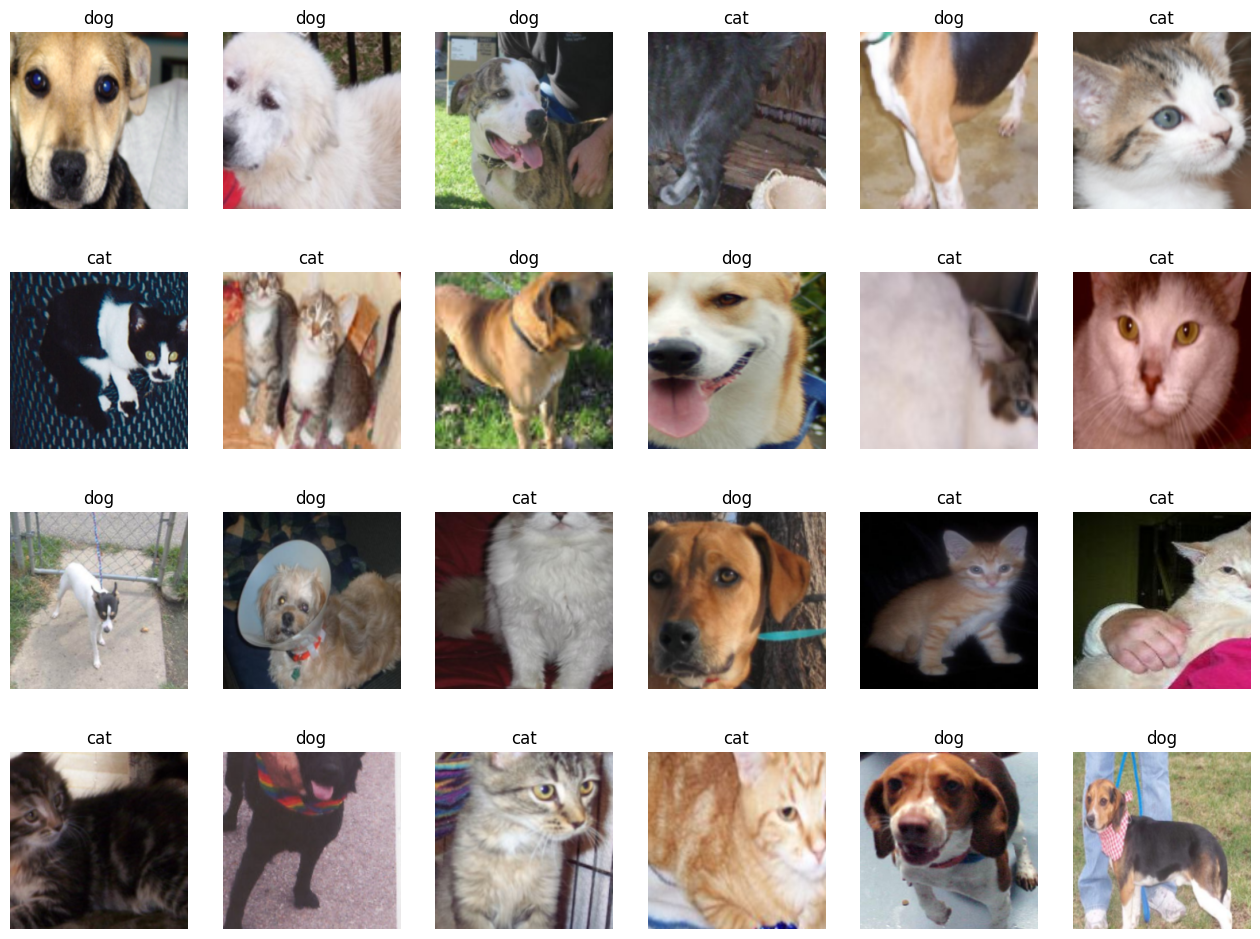

In [ ]:
import numpy as np
samples, labels = next(iter(train_loader))
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    # (C, H, W) -> (H, W, C) 변경
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))

# subplot간의 간격 조절
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [ ]:
dir(models)

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'

In [ ]:
resnet18 = models.resnet18(pretrained=True)

전이학습(transfer learning)

사전에 훈련된 모델의 가중치를 가져와 해결하려는 문제에 맞게 변형해서 사용하는 것을 의미합니다.

전이학습은 두 가지 방법으로 나눌 수 있습니다.
- 특성 추출 기법(feature extraction) : 사전 훈련된 모델 중 완전연결층 부분만 새로 만들고, 학습 시 완전연결층(분류기) 부분만 학습하도록 하는 기법
- 미세조정(fine tuning) : 사전 학습된 모델의 일부 층, 혹은 전체를 개방하여 기존 학습된 웨이트에서 이어서 학습하는 방법으로, 사전 학습된 모델이 현재 해결하려는 문제와 비슷할 때 사용하는 기법



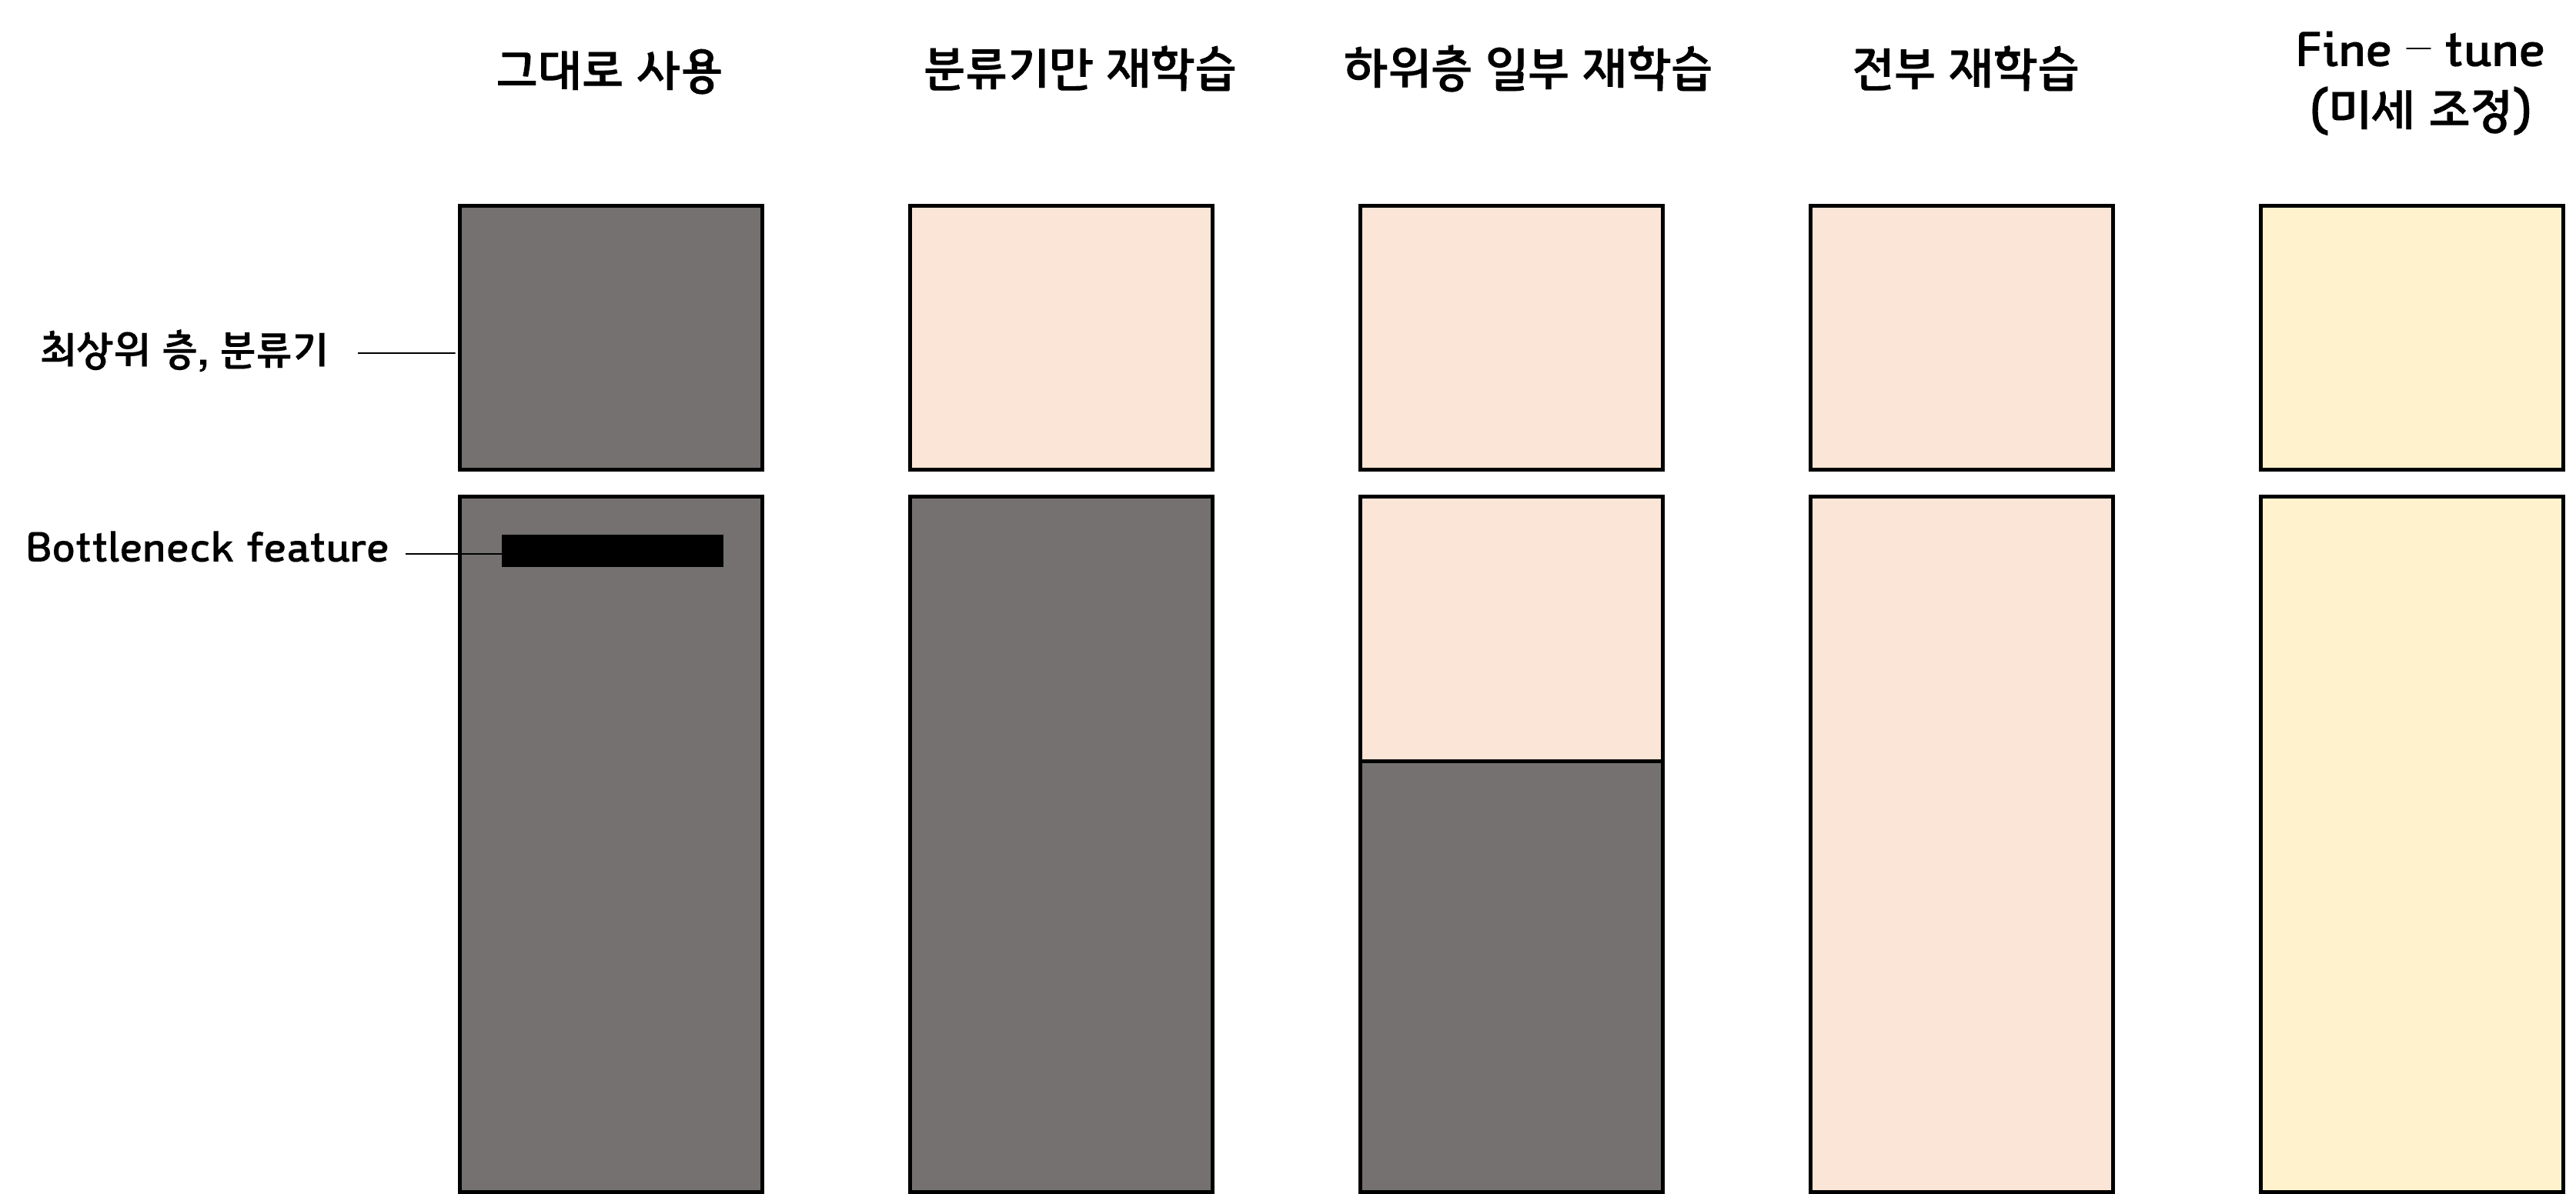

In [ ]:
for param in resnet18.parameters():
    print(param)

Parameter containing:
tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
            1.7083e-02, -1.2694e-02],
          [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
           -1.2907e-01,  3.7424e-03],
          [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
            2.5632e-01,  6.3573e-02],
          ...,
          [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
           -4.2058e-01, -2.5781e-01],
          [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
            3.9359e-01,  1.6606e-01],
          [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
           -8.2230e-02, -5.7828e-03]],

         [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
            6.6221e-04, -2.5743e-02],
          [ 4.5687e-02,  3.3603e-02, -1.0453e-01,  ..., -3.1253e-01,
           -1.6051e-01, -1.2826e-03],
          [-8.3730e-04,  9.8420e-02,  4.0210e-01,  ...,  7.0789e-01,
            3.6887e-01,  1.2455e-01]

In [ ]:
# 모델의 일부 파라미터를 고정(freeze)하고 나머지 파라미터만 학습
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        # 모델의 파라미터 층마다 반환
        for param in model.parameters():
            param.requires_grad = False # 학습하지 않을 부분만 고정

set_parameter_requires_grad(resnet18)

In [ ]:
# 학습(업데이트) 가능한 파라미터 확인

total_params = sum(p.numel() for p in resnet18.parameters())
trainable_params = sum(p.numel() for p in resnet18.parameters() if p.requires_grad) # p.requires_grad=True일 떄 True일때만 학습한다


total_params, trainable_params

(11689512, 0)

In [ ]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

위 결과에 있는 (fc): Linear(in_features=512, out_features=1000, bias=True) 이 부분을 다른 것으로 바꾼다

최종 출력층을 우리의 목적에 맞게 수정해야 합니다.

- 최종 출력 층 노드 수 1개(이진분류)
- 시그모이드 함수 통과

In [ ]:
# 기존 fc 레이어의 입력 특징 수를 가져옵니다 (512)
fc_in = resnet18.fc.in_features
fc_in

512

In [ ]:
resnet18.fc

Linear(in_features=512, out_features=1000, bias=True)

In [ ]:
# 기존 fc 레이어의 입력 특징 수를 가져옵니다 (512)
fc_in = resnet18.fc.in_features

# 새로운 fc 레이어 정의 (출력 뉴런을 1로 변경)
resnet18.fc = nn.Sequential(
    nn.Linear(resnet18.fc.in_features, 1), # 자동적으로 미분
    nn.Sigmoid())

In [ ]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
for name, param in resnet18.named_parameters():
    if param.requires_grad: # True 학습 가능
        print(name, param.data)

fc.0.weight tensor([[-1.7941e-02,  2.4843e-02,  3.8082e-02,  3.9485e-02, -2.0476e-02,
          2.1539e-02, -2.0458e-02,  6.2373e-03,  2.9690e-03, -3.2863e-02,
          2.9794e-02,  3.0275e-02, -6.6391e-03,  1.8402e-02,  1.3444e-02,
         -2.6656e-02,  3.7179e-02, -3.1682e-02,  4.2127e-02,  3.2495e-02,
          7.0370e-03,  6.4004e-03,  4.3994e-02, -1.6151e-02,  5.9616e-03,
         -3.0746e-02,  3.3076e-02,  4.0299e-02, -3.8381e-02,  3.1441e-02,
          1.1116e-02,  2.4859e-02,  3.6676e-02, -2.4203e-02, -1.9910e-02,
         -3.5156e-02, -2.4570e-02, -4.2512e-02, -3.6202e-03, -2.3973e-02,
          9.9772e-03, -1.6384e-02, -2.6844e-02, -3.8657e-02,  3.4790e-02,
          2.7500e-02,  4.1728e-02, -2.5799e-02,  1.2492e-02,  2.9532e-02,
         -2.4104e-02,  3.1945e-03,  3.6557e-02, -3.8378e-02, -4.2600e-02,
          2.8577e-02,  3.5823e-02, -6.5688e-04, -1.3074e-02,  1.1622e-02,
          7.1466e-03,  2.4089e-02, -3.0897e-02,  4.1825e-02,  3.2427e-02,
         -3.0231e-02,  5.9

In [ ]:
resnet18.fc.parameters()

<generator object Module.parameters at 0x7d8b43101930>

최종 출력층은 새로 생성했기 때문에 학습이 가능합니다.

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
    since = time.time()
    acc_history = []
    loss_history = []
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0.0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1).float() # unsqueeze(1).float() torch.Size([32]) -> [32,[]: 이차원 (예측) [32]: 일차원(실제값)

            model.to(device)
            optimizer.zero_grad() # 기울기 초기화
            outputs = model(inputs) # 순전파
            loss = criterion(outputs, labels) # 오차
            # 이진분류 0 ~ 1 0.5 보다 크면 1 작으면 0
            preds = (outputs >0.5)
            #  torch.argmax(outputs, 1): 다중 분류 3 -> [0.2, 0.7, 3.5]
            loss.backward()
            optimizer.step() # 기울기 업데이트

            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders)
        epoch_acc = running_corrects / len(train_dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join('catanddog/', f'{epoch:02d}.pth'))
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Acc: {best_acc:.4f}')
    return acc_history, loss_history

In [ ]:
optimizer = optim.Adam(resnet18.parameters(),lr=0.01) # 아래 코드와 동일하다(속도차이)

In [ ]:
params_to_update = []
for name,param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

optimizer = optim.Adam(params_to_update,lr=0.01) # 최적화

	 fc.0.weight
	 fc.0.bias


In [ ]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.BCELoss()
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device) # 훈련 정확도이다

Epoch 0/12
----------
Loss: 0.6364 Acc: 0.6987

Epoch 1/12
----------
Loss: 0.3312 Acc: 0.8675

Epoch 2/12
----------
Loss: 0.5943 Acc: 0.8208

Epoch 3/12
----------
Loss: 0.3553 Acc: 0.8857

Epoch 4/12
----------
Loss: 0.3660 Acc: 0.8416

Epoch 5/12
----------
Loss: 0.4325 Acc: 0.8805

Epoch 6/12
----------
Loss: 0.2277 Acc: 0.9143

Epoch 7/12
----------
Loss: 0.1858 Acc: 0.9143

Epoch 8/12
----------
Loss: 0.2259 Acc: 0.9351

Epoch 9/12
----------
Loss: 0.4280 Acc: 0.9091

Epoch 10/12
----------
Loss: 0.4464 Acc: 0.8961

Epoch 11/12
----------
Loss: 0.2171 Acc: 0.9195

Epoch 12/12
----------
Loss: 0.2943 Acc: 0.9143

Training complete in 0m 32s
Best Acc: 0.9351


In [ ]:
test_path = 'catanddog/test/'

transform = transforms.Compose(
                [
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                ])
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

98


In [ ]:
def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    # glob : 현재 디렉토리에서 원하는 파일들만 추출해서 가져올 때 사용
    saved_models = glob.glob('catanddog/' + '*.pth')
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval() # 검증
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad(): # 예측
                outputs = model(inputs)

            preds =(outputs > 0.5)
            running_corrects += torch.sum(preds == labels.data)

        epoch_acc = running_corrects / len(test_dataset)
        print('Acc: {:.4f}'.format(epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))

    return acc_history

In [ ]:
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['catanddog/00.pth', 'catanddog/01.pth', 'catanddog/02.pth', 'catanddog/03.pth', 'catanddog/04.pth', 'catanddog/05.pth', 'catanddog/06.pth', 'catanddog/07.pth', 'catanddog/08.pth', 'catanddog/09.pth', 'catanddog/10.pth', 'catanddog/11.pth', 'catanddog/12.pth']
Loading model catanddog/00.pth
Acc: 15.6735

Loading model catanddog/01.pth
Acc: 16.2857

Loading model catanddog/02.pth
Acc: 16.0816

Loading model catanddog/03.pth
Acc: 16.1633

Loading model catanddog/04.pth
Acc: 15.8367

Loading model catanddog/05.pth
Acc: 15.7551

Loading model catanddog/06.pth
Acc: 16.0408

Loading model catanddog/07.pth
Acc: 16.0612

Loading model catanddog/08.pth
Acc: 16.2245

Loading model catanddog/09.pth
Acc: 15.8571

Loading model catanddog/10.pth
Acc: 15.7755

Loading model catanddog/11.pth
Acc: 15.8980

Loading model catanddog/12.pth
Acc: 15.8163

Validation complete in 0m 7s
Best Acc: 16.285713


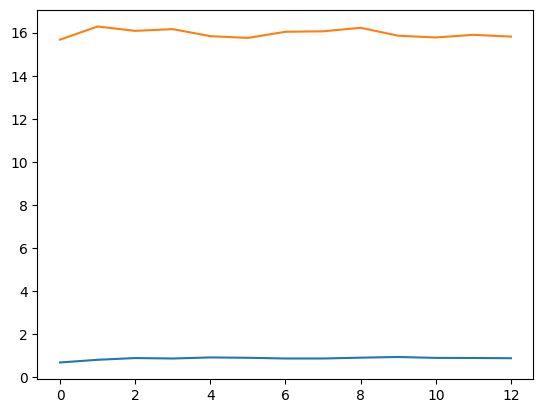

In [ ]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

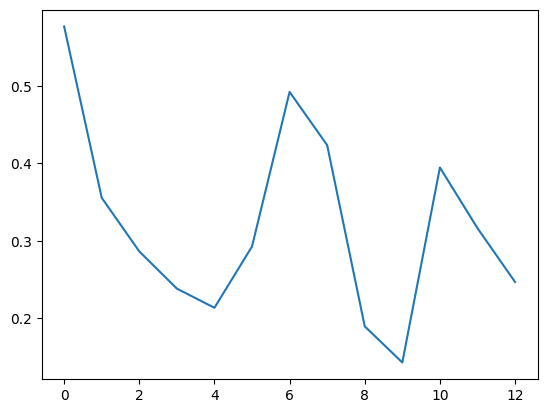

In [ ]:
plt.plot(train_loss_hist)
plt.show()

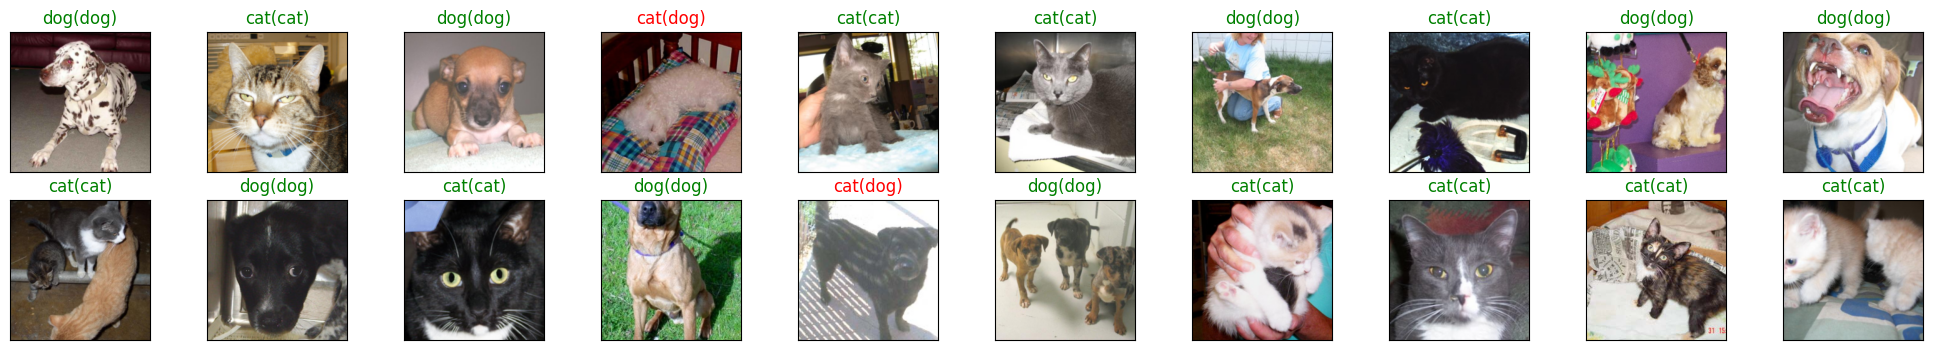

<Figure size 640x480 with 0 Axes>

In [ ]:
classes = {0:'cat', 1:'dog'}

images,labels= next(iter(test_loader))
resnet18.to('cpu')
output = resnet18(images)
preds = (output > 0.5)

fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax=fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])
    plt.imshow(images[idx].numpy().transpose(1, 2, 0))
    a.set_title(classes[labels[i].item()])
    ax.set_title("{}({})".format(classes[preds[idx].item()],classes[labels[idx].item()]),color=("green" if preds[idx]==labels[idx] else "red"))
plt.show()
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

## 3) 특성 맵 시각화

CNN을 구성하는 중간 계층부터 최종 분류까지 입력된 이미지로부터 특성이 어떻게 추출되는지 시각적으료 표현할 수 있습니다.

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.transforms import ToTensor
import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class MyModel(torch.nn.Module):
    def __init__(self, num_classes=2):
        super(MyModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(64, 64, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(128, 128, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 512, bias=False),
            nn.Dropout(0.5),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 512)
        x = self.classifier(x)
        return F.sigmoid(x)

In [ ]:
model=MyModel()
model.cpu()
model

MyModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=

특성맵을 시각화하여 볼 수 있는 함수를 정의하겠습니다.

특성맵은 합성곱층을 통해 입력 이미지와 필터를 연산하여 얻은 결과를 의미합니다.

In [ ]:
class LayerActivations:
    def __init__(self, model, layer_num): # 몇층에 결과를
        # 출력할 특성맵 정의
        self.features = []
        # register_forward_hook : 순전파 연산 중 각 네트워크 모듈의 입력 및 출력 값을 가져옴(특정 레이어가 입력을 받아 출력을 생성할 때마다 그 출력을 가로챔)
        # 가로챈 출력이 self.hook_fn함수로 전달
        self.hook = model[layer_num].register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        self.features.append(output.detach().numpy())
    def remove(self):
        self.hook.remove()

Saving cat.jpg to cat (1).jpg
(1080, 1920, 3)


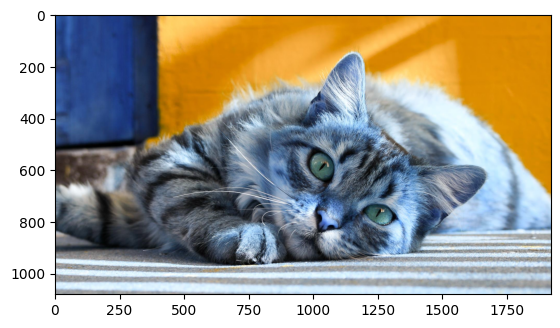

In [ ]:
from google.colab import files # 데이터 불러오기
file_uploaded=files.upload()   # data/cat.jpg 데이터 불러오기

img=cv2.imread("cat.jpg")
print(img.shape)
plt.imshow(img)

torch.Size([1, 3, 100, 100])


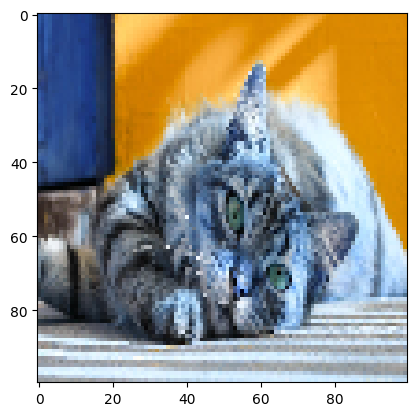

In [ ]:
img = cv2.resize(img, (100, 100), interpolation=cv2.INTER_LINEAR)
plt.imshow(img)
img = torch.tensor(img,dtype=torch.float32).permute(2,0,1).unsqueeze(dim=0) # .unsqueeze(dim=0) 배치 크기


print(img.shape)

In [ ]:
result = LayerActivations(model.features, 0)
model.eval()
model(img)

# 이미지에 대한
activations = result.features

In [ ]:
activations[0].shape

(1, 64, 98, 98)

우선 첫번째 conv층을 통과했을 때의 특성맵을 확인해보겠습니다.

입력층과 가까운 계층일수록 입력 이미지의 형태가 유지됩니다.

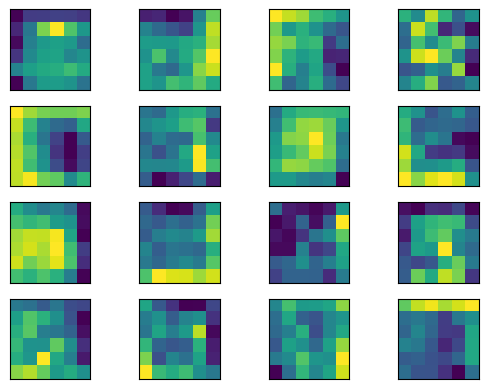

<Figure size 1200x800 with 0 Axes>

In [ ]:
fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][0][row*10+column])
plt.show()

In [ ]:
result = LayerActivations(model.features, 20)

model(img)
activations = result.features

다음으로 20번째 계층에 대한 특성 맵입니다.

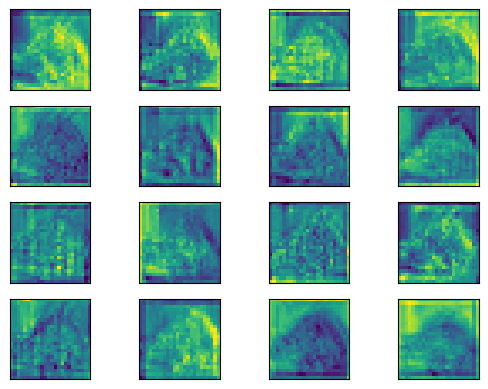

<Figure size 1200x800 with 0 Axes>

In [ ]:

fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][0][row*10+column])
plt.show()

In [ ]:
result = LayerActivations(model.features, 40)

model(img)
activations = result.features

마지막으로 40번째 계층의 특성맵을 살펴보겠습니다.

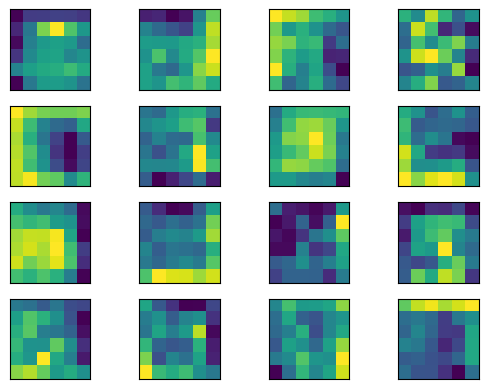

<Figure size 1200x800 with 0 Axes>

In [ ]:
fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][0][row*10+column])
plt.show()

출력층에 가까울수록 이미지의 형태는 찾아보기 힘들고, 이미지의 특징만 전달되는 것을 확인할 수 있습니다.

이는 이미지 정보가 점차 압축되어 추상적이고 고수준의 표현으로 변환되었기 때문입니다.
